In [ ]:
import os
import gc
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns

from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score as ras
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import lightgbm as lgb
import xgboost as xgb

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
PATH = './drive/MyDrive/SisFall_Preprocessed/'

In [ ]:
users = pd.read_csv(os.path.join(PATH, 'user_details.csv'))
feats = pd.read_csv(os.path.join(PATH, 'user_compressed_feats.csv'),)

sub = pd.DataFrame(feats[['user_test', 'target']].values, columns=['user_test','target'])
sub['target'] = sub['target'].astype(int)
sub['prediction'] = 0

print(f'Data Shape : {feats.shape}')

Data Shape : (4447, 29)


In [ ]:
feats['user_id'] = feats['user_test'].apply(lambda x:x.split('_')[1])
feats = feats.merge(users, how='left', on='user_id')
feats['gender'] = feats['gender'].map({'M':0,'F':1})

use_cols = [x for x in feats.columns if x not in ['user_test','user_id','target']]

In [ ]:
init_params = {'boosting_type': 'gbdt', 'max_depth': -1, 'objective': 'binary', 
          'num_leaves': 64, 'learning_rate': 0.05, 'max_bin': 512, 
          'subsample_for_bin': 200, 'subsample': 1, 'subsample_freq': 1,
          'colsample_bytree': 0.8, 'reg_alpha': 5, 'reg_lambda': 10, 
          'min_split_gain': 0.5, 'min_child_weight': 1, 
          'min_child_samples': 5, 'scale_pos_weight': 1, 'num_class': 1, 
          'metric': 'binary_error',
          'verbosity':0}

In [ ]:
init_params = {'boosting_type': 'gbdt', 'max_depth': -1, 'objective': 'binary', 
          'num_leaves': 64, 'learning_rate': 0.05, 'max_bin': 512, 
          'subsample_for_bin': 200, 'subsample': 1, 'subsample_freq': 1,
          'colsample_bytree': 0.8, 'reg_alpha': 5, 'reg_lambda': 10, 
          'min_split_gain': 0.5, 'min_child_weight': 1, 
          'min_child_samples': 5, 'scale_pos_weight': 1, 'num_class': 1, 
          'metric': 'binary_error',
          'verbosity':0}

grid_params = {'learning_rate': [0.01, 0.025, 0.05], 'n_estimators': [8, 24],
               'num_leaves': [6, 8, 12, 16], 'boosting_type': ['gbdt'], 
               'objective': ['binary'],
               'colsample_bytree': [0.65, 0.75, 0.8], 
               'subsample': [0.7, 0.75], 'reg_alpha': [1, 2, 6],
               'reg_lambda': [1, 2, 6]}

In [ ]:
N_SPLITS = 5
folds = StratifiedKFold(n_splits=N_SPLITS)

model = lgb.LGBMClassifier(**init_params)
grid = GridSearchCV(estimator=model, param_grid=grid_params,
                    scoring='roc_auc', n_jobs=-1,
                    cv=folds, verbose=3)
grid.fit(feats[use_cols], feats['target'])

Fitting 5 folds for each of 1296 candidates, totalling 6480 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=LGBMClassifier(colsample_bytree=0.8, learning_rate=0.05,
                                      max_bin=512, metric='binary_error',
                                      min_child_samples=5, min_child_weight=1,
                                      min_split_gain=0.5, num_class=1,
                                      num_leaves=64, objective='binary',
                                      reg_alpha=5, reg_lambda=10,
                                      scale_pos_weight=1, subsample=1,
                                      subsample_for_bin=200, subsample_freq=1,
                                      verbosity=0),
             n_jobs=-1,
             param_grid={'boosting_type': ['gbdt'],
                         'colsample_bytree': [0.65, 0.75, 0.8],
                         'learning_rate': [0.01, 0.025, 0.05],
                         'n_estimators': [8, 24], 'num_leaves': [6, 8, 12

In [ ]:
best_params = {k: grid.best_params_.get(k, v) for k, v in init_params.items()}
best_params['verbosity'] = 0
best_params['metric'] = 'binary_error'
best_params

{'boosting_type': 'gbdt',
 'colsample_bytree': 0.75,
 'learning_rate': 0.05,
 'max_bin': 512,
 'max_depth': -1,
 'metric': 'binary_error',
 'min_child_samples': 5,
 'min_child_weight': 1,
 'min_split_gain': 0.5,
 'num_class': 1,
 'num_leaves': 16,
 'objective': 'binary',
 'reg_alpha': 1,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 0.75,
 'subsample_for_bin': 200,
 'subsample_freq': 1,
 'verbosity': 0}

In [ ]:
train_df, test_df, train_target, test_target = train_test_split(feats[use_cols],
                                                                feats['target'],
                                                                test_size=0.1,
                                                                stratify=feats['target'])
lgb_train_data = lgb.Dataset(train_df, label=train_target)
lgb_test_data = lgb.Dataset(test_df, label=test_target)

model = lgb.train(best_params, lgb_train_data, 
                  num_boost_round=10000,
                  valid_sets = [lgb_test_data],
                  early_stopping_rounds=100,
                  verbose_eval=100)

feat_imp = [(model.feature_importance()[i], feats[use_cols].columns[i])
            for i in range(len(use_cols))]
feat_imp = sorted(feat_imp, key=lambda x:x[0], reverse=True)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_error: 0.00449438
[200]	valid_0's binary_error: 0.00224719
Early stopping, best iteration is:
[131]	valid_0's binary_error: 0.00224719


In [ ]:
kfeat = 2
use_feat_imp = [fi for fi in feat_imp][:kfeat]
print(f'Features Using : {use_feat_imp}')
use_feat_imp = [fi[-1] for fi in feat_imp][:kfeat]

Features Using : [(113, 'age'), (104, 'std_C3')]


In [ ]:
score = []
for fold, (trn_idx, val_idx) in tqdm(enumerate(folds.split(feats, feats['target'])),total=5):
  print(f'Training on fold : {fold+1}')
  train_df, test_df = feats[use_feat_imp].iloc[trn_idx], feats[use_feat_imp].iloc[val_idx]
  train_target, test_target = feats['target'].iloc[trn_idx], feats['target'].iloc[val_idx]
  
  lgb_train_data = lgb.Dataset(train_df, label=train_target)
  lgb_test_data = lgb.Dataset(test_df, label=test_target)

  model = lgb.train(best_params, lgb_train_data, 
                    num_boost_round=50000,
                    valid_sets = [lgb_test_data],
                    early_stopping_rounds=1000,
                    verbose_eval=0)
  val_preds = model.predict(test_df, num_iteration=model.best_iteration)/N_SPLITS
  sub.loc[sub.index.isin(val_idx), 'prediction'] += val_preds
  score.append(ras(test_target, val_preds))
  print(f'fold {fold}, Validation Predicition ROC-AUC : {score[-1]}')
  print('==============================================')

oof_score = sum(score)/N_SPLITS
print(f'OOF ROC-AUC Score : {oof_score}')

  0%|          | 0/5 [00:00<?, ?it/s]

Training on fold : 1
fold 0, Validation Predicition ROC-AUC : 0.9830896226415095
Training on fold : 2
fold 1, Validation Predicition ROC-AUC : 0.9814255765199162
Training on fold : 3
fold 2, Validation Predicition ROC-AUC : 0.9632390813055133
Training on fold : 4
fold 3, Validation Predicition ROC-AUC : 0.9685446996373575
Training on fold : 5
fold 4, Validation Predicition ROC-AUC : 0.9435964083175803
OOF ROC-AUC Score : 0.9679790776843753


In [ ]:
sub.to_csv(os.path.join(PATH, 'sub_lgb.csv'), index=False)

In [ ]:
import glob
files = glob.glob('./drive/MyDrive/SisFall_Preprocessed/*/*')
files

['./drive/MyDrive/SisFall_Preprocessed/SA01/D12_SA01_R04.txt',
 './drive/MyDrive/SisFall_Preprocessed/SA01/D14_SA01_R05.txt',
 './drive/MyDrive/SisFall_Preprocessed/SA01/D14_SA01_R02.txt',
 './drive/MyDrive/SisFall_Preprocessed/SA01/D17_SA01_R04.txt',
 './drive/MyDrive/SisFall_Preprocessed/SA01/F02_SA01_R04.txt',
 './drive/MyDrive/SisFall_Preprocessed/SA01/D17_SA01_R05.txt',
 './drive/MyDrive/SisFall_Preprocessed/SA01/D11_SA01_R05.txt',
 './drive/MyDrive/SisFall_Preprocessed/SA01/F09_SA01_R02.txt',
 './drive/MyDrive/SisFall_Preprocessed/SA01/F02_SA01_R03.txt',
 './drive/MyDrive/SisFall_Preprocessed/SA01/D13_SA01_R04.txt',
 './drive/MyDrive/SisFall_Preprocessed/SA01/F02_SA01_R01.txt',
 './drive/MyDrive/SisFall_Preprocessed/SA01/F04_SA01_R01.txt',
 './drive/MyDrive/SisFall_Preprocessed/SA01/D08_SA01_R02.txt',
 './drive/MyDrive/SisFall_Preprocessed/SA01/D16_SA01_R05.txt',
 './drive/MyDrive/SisFall_Preprocessed/SA01/D05_SA01_R05.txt',
 './drive/MyDrive/SisFall_Preprocessed/SA01/D10_SA01_R0

In [ ]:
file_path = np.random.choice(files)
print(file_path)
df = pd.read_csv(open(file_path),
             header=None, sep = ' ',
             names = [f'C{i}' for i in range(9)])

./drive/MyDrive/SisFall_Preprocessed/SA09/D12_SA09_R02.txt


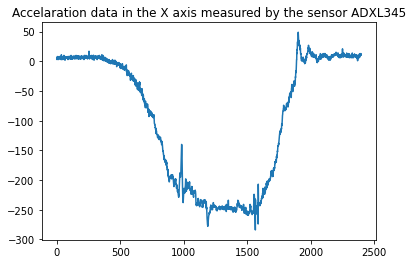

In [ ]:
_ = plt.plot(df['C0'])
_ = plt.title('Accelaration data in the X axis measured by the sensor ADXL345')

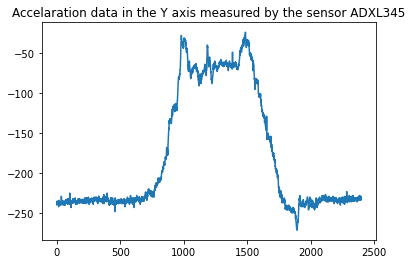

In [ ]:
_ = plt.plot(df['C1'])
_ = plt.title('Accelaration data in the Y axis measured by the sensor ADXL345')

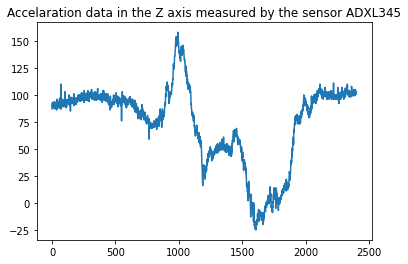

In [ ]:
_ = plt.plot(df['C2'])
_ = plt.title('Accelaration data in the Z axis measured by the sensor ADXL345')

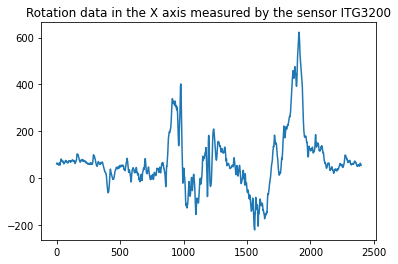

In [ ]:
_ = plt.plot(df['C3'])
_ = plt.title('Rotation data in the X axis measured by the sensor ITG3200')

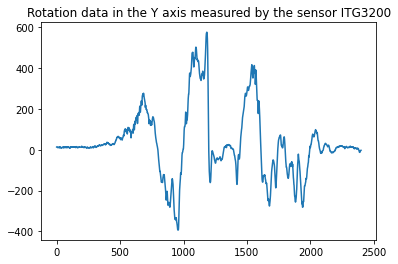

In [ ]:
_ = plt.plot(df['C4'])
_ = plt.title('Rotation data in the Y axis measured by the sensor ITG3200')

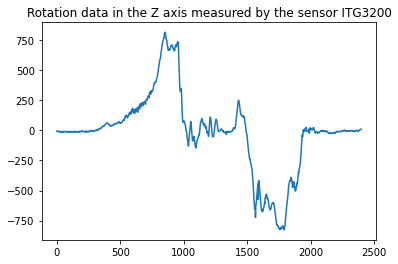

In [ ]:
_ = plt.plot(df['C5'])
_ = plt.title('Rotation data in the Z axis measured by the sensor ITG3200')